<a href="https://colab.research.google.com/github/shauryasawai/Experiment_b_medical/blob/main/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
import os
from tqdm import tqdm
import zipfile
import shutil

In [19]:
# ==================== Google Colab Setup ====================
def setup_colab():
    """Setup Google Colab environment"""
    try:
        from google.colab import files, drive
        print("✓ Running in Google Colab")
        return True
    except ImportError:
        print("✗ Not running in Google Colab")
        return False

def upload_and_extract_dataset():
    """Upload and extract dataset folders in Colab"""
    from google.colab import files

    print("\n" + "="*70)
    print("Dataset Upload")
    print("="*70)
    print("\nPlease prepare TWO zip files:")
    print("  1. images.zip - containing all ultrasound images")
    print("  2. masks.zip - containing all corresponding masks")
    print("\nMake sure image and mask filenames match (e.g., img001.png and img001.png)")
    print("\n" + "-"*70)

    # Create directories
    os.makedirs('dataset/images', exist_ok=True)
    os.makedirs('dataset/masks', exist_ok=True)

    # Upload images
    print("\n📤 Step 1: Upload images.zip")
    print("Click 'Choose Files' and select your images.zip file...")
    uploaded_images = files.upload()

    if 'images.zip' in uploaded_images:
        print("✓ Extracting images...")
        with zipfile.ZipFile('images.zip', 'r') as zip_ref:
            zip_ref.extractall('dataset/images/')
        os.remove('images.zip')
        print("✓ Images extracted successfully!")
    else:
        print("✗ images.zip not found!")
        return None, None

    # Upload masks
    print("\n📤 Step 2: Upload masks.zip")
    print("Click 'Choose Files' and select your masks.zip file...")
    uploaded_masks = files.upload()

    if 'masks.zip' in uploaded_masks:
        print("✓ Extracting masks...")
        with zipfile.ZipFile('masks.zip', 'r') as zip_ref:
            zip_ref.extractall('dataset/masks/')
        os.remove('masks.zip')
        print("✓ Masks extracted successfully!")
    else:
        print("✗ masks.zip not found!")
        return None, None

    # Get file paths
    image_dir = Path('dataset/images')
    mask_dir = Path('dataset/masks')

    # Find all images (handle nested folders)
    image_paths = []
    for ext in ['*.png', '*.jpg', '*.jpeg', '*.bmp']:
        image_paths.extend(list(image_dir.rglob(ext)))

    # Find all masks
    mask_paths = []
    for ext in ['*.png', '*.jpg', '*.jpeg', '*.bmp']:
        mask_paths.extend(list(mask_dir.rglob(ext)))

    image_paths = sorted(image_paths)
    mask_paths = sorted(mask_paths)

    print(f"\n✓ Dataset loaded successfully!")
    print(f"  Images found: {len(image_paths)}")
    print(f"  Masks found: {len(mask_paths)}")

    if len(image_paths) != len(mask_paths):
        print("\n⚠ Warning: Number of images and masks don't match!")
        print("  Please ensure each image has a corresponding mask with the same filename.")

    return image_paths, mask_paths

In [20]:
# ==================== Attention U-Net Architecture ====================
class DoubleConv(nn.Module):
    """(Conv -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class AttentionBlock(nn.Module):
    """Attention Gate for focusing on relevant features"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    """Attention U-Net for Medical Image Segmentation"""

    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Decoder + Attention
        for feature in reversed(features):
            # Upsample
            self.decoder.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )

            # ✅ FIXED Attention Gate
            self.attention_blocks.append(
                AttentionBlock(
                    F_g=feature,      # decoder channels
                    F_l=feature,      # skip channels
                    F_int=feature // 2
                )
            )

            # Conv after concat
            self.decoder.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # upsample
            skip = skip_connections[idx // 2]

            if x.shape[2:] != skip.shape[2:]:
                x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=True)

            skip = self.attention_blocks[idx // 2](g=x, x=skip)
            x = torch.cat((skip, x), dim=1)
            x = self.decoder[idx + 1](x)

        return torch.sigmoid(self.final_conv(x))

In [21]:
# ==================== Dataset ====================
class FetalCraniumDataset(Dataset):
    """Dataset for fetal ultrasound images and cranium masks"""

    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(str(self.image_paths[idx]), cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(str(self.mask_paths[idx]), cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise ValueError(f"Could not load image or mask at index {idx}")

        image = image.astype(np.float32) / 255.0
        mask  = (mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']   # [1, H, W]
            mask  = augmented['mask']    # [1, H, W]

        # ✅ DO NOT add channel again
        return image, mask

In [22]:
# ==================== Loss Functions ====================
def dice_coefficient(pred, target, smooth=1e-5):
    """
    pred   : [B, 1, H, W]
    target : [B, 1, H, W]
    """

    # 🔒 Enforce channel dimension
    if target.dim() == 3:
        target = target.unsqueeze(1)

    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def dice_loss(pred, target, smooth=1e-5):
    return 1 - dice_coefficient(pred, target, smooth)

def combined_loss(pred, target):
    """
    pred   : [B, 1, H, W]
    target : [B, 1, H, W]
    """

    if target.dim() == 3:
        target = target.unsqueeze(1)

    bce = F.binary_cross_entropy(pred, target)
    dice = dice_loss(pred, target)

    return bce + dice

def calculate_metrics(pred, target, threshold=0.5):
    """
    pred   : [B, 1, H, W]
    target : [B, 1, H, W]
    """

    if target.dim() == 3:
        target = target.unsqueeze(1)

    pred_bin = (pred > threshold).float()
    target = target.float()

    intersection = (pred_bin * target).sum(dim=(2, 3))
    union = pred_bin.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection

    iou = (intersection + 1e-5) / (union + 1e-5)
    dice = (2 * intersection + 1e-5) / (
        pred_bin.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + 1e-5
    )

    return iou.mean().item(), dice.mean().item()

In [23]:
# ==================== Training Functions ====================
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss, total_dice, total_iou = 0, 0, 0

    pbar = tqdm(dataloader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks  = masks.to(device)

        # 🔒 ALWAYS enforce channel dimension
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)

        # 🔒 Absolute safety check
        assert outputs.shape == masks.shape, \
            f"Output {outputs.shape} vs Mask {masks.shape}"

        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        iou, dice = calculate_metrics(outputs, masks)

        total_loss += loss.item()
        total_dice += dice
        total_iou += iou

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}'
        })

    return total_loss / len(dataloader), total_dice / len(dataloader), total_iou / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    total_loss, total_dice, total_iou = 0, 0, 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks  = masks.to(device)

            if masks.dim() == 3:
                masks = masks.unsqueeze(1)

            outputs = model(images)

            assert outputs.shape == masks.shape, \
                f"Output {outputs.shape} vs Mask {masks.shape}"

            loss = combined_loss(outputs, masks)
            iou, dice = calculate_metrics(outputs, masks)

            total_loss += loss.item()
            total_dice += dice
            total_iou += iou

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}'
            })

    return total_loss / len(dataloader), total_dice / len(dataloader), total_iou / len(dataloader)

def train_attention_unet(model, train_loader, val_loader, epochs=50, lr=1e-4, device='cuda', save_path='attention_unet_best.pth'):
    """Complete training pipeline"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5
    )

    best_val_dice = 0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_dice': [], 'val_dice': [],
        'train_iou': [], 'val_iou': []
    }

    print(f"\n{'='*70}")
    print(f"Training Attention U-Net")
    print(f"{'='*70}\n")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)

        train_loss, train_dice, train_iou = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_dice, val_iou = validate_epoch(model, val_loader, device)

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)
        history['train_iou'].append(train_iou)
        history['val_iou'].append(val_iou)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_loss': val_loss,
                'val_iou': val_iou,
            }, save_path)
            print(f"  ✓ Saved best model! (Dice: {best_val_dice:.4f})")

    return history, best_val_dice

In [24]:
# ==================== Biometry Detection ====================
def fit_ellipse_to_mask(mask):
    """Fit ellipse to segmented cranium"""
    contours, _ = cv2.findContours(
        mask.astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    if len(contours) == 0:
        return None

    contour = max(contours, key=cv2.contourArea)

    if len(contour) < 5:
        return None

    ellipse = cv2.fitEllipse(contour)
    return ellipse

def calculate_biometry_points(ellipse):
    """Calculate BPD and OFD landmark points"""
    center, axes, angle = ellipse
    cx, cy = center
    major_axis, minor_axis = axes

    angle_rad = np.deg2rad(angle)

    A = (
        int(cx + (major_axis/2) * np.cos(angle_rad)),
        int(cy + (major_axis/2) * np.sin(angle_rad))
    )
    C = (
        int(cx - (major_axis/2) * np.cos(angle_rad)),
        int(cy - (major_axis/2) * np.sin(angle_rad))
    )

    B = (
        int(cx - (minor_axis/2) * np.sin(angle_rad)),
        int(cy + (minor_axis/2) * np.cos(angle_rad))
    )
    D = (
        int(cx + (minor_axis/2) * np.sin(angle_rad)),
        int(cy - (minor_axis/2) * np.cos(angle_rad))
    )

    return A, C, B, D

def segment_and_measure(model, image_path, device='cuda', target_size=256):
    """Complete pipeline: segment and measure"""
    original_image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    original_size = original_image.shape

    image_resized = cv2.resize(original_image, (target_size, target_size))
    image_tensor = torch.from_numpy(image_resized.astype(np.float32) / 255.0)
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        pred_mask = model(image_tensor)
        pred_mask = (pred_mask > 0.5).float()

    mask = pred_mask.squeeze().cpu().numpy()
    mask = cv2.resize(mask, (original_size[1], original_size[0]))
    mask = (mask > 0.5).astype(np.uint8) * 255

    ellipse = fit_ellipse_to_mask(mask)
    if ellipse is None:
        return None, mask, original_image

    A, C, B, D = calculate_biometry_points(ellipse)

    BPD = np.sqrt((A[0] - C[0])**2 + (A[1] - C[1])**2)
    OFD = np.sqrt((B[0] - D[0])**2 + (B[1] - D[1])**2)

    biometry_data = {
        'ellipse': ellipse,
        'BPD_points': (A, C),
        'OFD_points': (B, D),
        'BPD_distance_px': BPD,
        'OFD_distance_px': OFD
    }

    return biometry_data, mask, original_image

def visualize_biometry(image_path, biometry_data, mask, save_path='biometry_result.png'):
    """Visualize segmentation and biometry"""
    original = cv2.imread(str(image_path))
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Ultrasound Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Cranium Segmentation', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    result_img = original.copy()
    if biometry_data:
        cv2.ellipse(result_img, biometry_data['ellipse'], (0, 255, 0), 2)

        A, C = biometry_data['BPD_points']
        cv2.line(result_img, A, C, (255, 0, 0), 3)
        cv2.circle(result_img, A, 6, (255, 0, 0), -1)
        cv2.circle(result_img, C, 6, (255, 0, 0), -1)
        cv2.putText(result_img, 'A', (A[0]-20, A[1]-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        cv2.putText(result_img, 'C', (C[0]+10, C[1]-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

        B, D = biometry_data['OFD_points']
        cv2.line(result_img, B, D, (0, 0, 255), 3)
        cv2.circle(result_img, B, 6, (0, 0, 255), -1)
        cv2.circle(result_img, D, 6, (0, 0, 255), -1)
        cv2.putText(result_img, 'B', (B[0]-20, B[1]),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        cv2.putText(result_img, 'D', (D[0]+10, D[1]),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        cv2.putText(result_img, f'BPD: {biometry_data["BPD_distance_px"]:.2f} px',
                   (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)
        cv2.putText(result_img, f'OFD: {biometry_data["OFD_distance_px"]:.2f} px',
                   (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)

    axes[2].imshow(result_img)
    axes[2].set_title('Biometry Measurements', fontsize=14, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Visualization saved to {save_path}")

✓ Running in Google Colab

Attention U-Net for Fetal Biometry Detection
Device: cuda


Dataset: 622 images, 622 masks

Training set: 497 images
Validation set: 125 images

Testing dataset shapes...
  Sample image shape: torch.Size([1, 256, 256])
  Sample mask shape: torch.Size([256, 256])
  Expected: [1, 256, 256] for both



/tmp/ipython-input-2727386488.py:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


Model Parameters: 31,388,013


Training Attention U-Net


Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.45it/s, loss=1.2860, dice=0.0000]



Epoch 1 Summary:
  Train - Loss: 1.3643, Dice: 0.0112, IoU: 0.0058
  Val   - Loss: 1.2793, Dice: 0.0005, IoU: 0.0003
  ✓ Saved best model! (Dice: 0.0005)

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.31it/s, loss=1.2430, dice=0.0000]



Epoch 2 Summary:
  Train - Loss: 1.2578, Dice: 0.0054, IoU: 0.0028
  Val   - Loss: 1.2390, Dice: 0.0026, IoU: 0.0014
  ✓ Saved best model! (Dice: 0.0026)

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  4.90it/s, loss=1.2189, dice=0.0065]



Epoch 3 Summary:
  Train - Loss: 1.2191, Dice: 0.0043, IoU: 0.0022
  Val   - Loss: 1.2136, Dice: 0.0215, IoU: 0.0112
  ✓ Saved best model! (Dice: 0.0215)

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  4.95it/s, loss=1.1848, dice=0.0057]



Epoch 4 Summary:
  Train - Loss: 1.1920, Dice: 0.0046, IoU: 0.0023
  Val   - Loss: 1.1808, Dice: 0.0025, IoU: 0.0013

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.44it/s, loss=1.1619, dice=0.0000]



Epoch 5 Summary:
  Train - Loss: 1.1671, Dice: 0.0027, IoU: 0.0014
  Val   - Loss: 1.1587, Dice: 0.0003, IoU: 0.0001

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s, loss=1.1479, dice=0.0089]



Epoch 6 Summary:
  Train - Loss: 1.1456, Dice: 0.0017, IoU: 0.0009
  Val   - Loss: 1.1458, Dice: 0.0209, IoU: 0.0109

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s, loss=1.1193, dice=0.0000]



Epoch 7 Summary:
  Train - Loss: 1.1272, Dice: 0.0053, IoU: 0.0027
  Val   - Loss: 1.1160, Dice: 0.0122, IoU: 0.0063

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.40it/s, loss=1.1100, dice=0.0038]



Epoch 8 Summary:
  Train - Loss: 1.1084, Dice: 0.0086, IoU: 0.0044
  Val   - Loss: 1.1077, Dice: 0.0222, IoU: 0.0115
  ✓ Saved best model! (Dice: 0.0222)

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.40it/s, loss=1.0962, dice=0.1515]



Epoch 9 Summary:
  Train - Loss: 1.0901, Dice: 0.0781, IoU: 0.0431
  Val   - Loss: 1.0897, Dice: 0.1797, IoU: 0.1005
  ✓ Saved best model! (Dice: 0.1797)

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.27it/s, loss=1.0795, dice=0.1425]



Epoch 10 Summary:
  Train - Loss: 1.0713, Dice: 0.1962, IoU: 0.1104
  Val   - Loss: 1.0693, Dice: 0.1784, IoU: 0.0994

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.20it/s, loss=1.0617, dice=0.1647]



Epoch 11 Summary:
  Train - Loss: 1.0564, Dice: 0.2004, IoU: 0.1129
  Val   - Loss: 1.0526, Dice: 0.1983, IoU: 0.1120
  ✓ Saved best model! (Dice: 0.1983)

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.25it/s, loss=1.0529, dice=0.1612]



Epoch 12 Summary:
  Train - Loss: 1.0395, Dice: 0.2118, IoU: 0.1198
  Val   - Loss: 1.0395, Dice: 0.1963, IoU: 0.1099

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.23it/s, loss=1.0217, dice=0.1980]



Epoch 13 Summary:
  Train - Loss: 1.0258, Dice: 0.2129, IoU: 0.1206
  Val   - Loss: 1.0095, Dice: 0.2182, IoU: 0.1236
  ✓ Saved best model! (Dice: 0.2182)

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.40it/s, loss=1.0255, dice=0.1791]



Epoch 14 Summary:
  Train - Loss: 1.0110, Dice: 0.2218, IoU: 0.1261
  Val   - Loss: 1.0101, Dice: 0.2192, IoU: 0.1241
  ✓ Saved best model! (Dice: 0.2192)

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s, loss=1.0009, dice=0.2165]



Epoch 15 Summary:
  Train - Loss: 0.9970, Dice: 0.2264, IoU: 0.1289
  Val   - Loss: 0.9888, Dice: 0.2236, IoU: 0.1269
  ✓ Saved best model! (Dice: 0.2236)

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s, loss=0.9918, dice=0.2042]



Epoch 16 Summary:
  Train - Loss: 0.9842, Dice: 0.2268, IoU: 0.1291
  Val   - Loss: 0.9785, Dice: 0.2193, IoU: 0.1244

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s, loss=0.9820, dice=0.2061]



Epoch 17 Summary:
  Train - Loss: 0.9712, Dice: 0.2306, IoU: 0.1316
  Val   - Loss: 0.9657, Dice: 0.2269, IoU: 0.1291
  ✓ Saved best model! (Dice: 0.2269)

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s, loss=0.9727, dice=0.1966]



Epoch 18 Summary:
  Train - Loss: 0.9588, Dice: 0.2339, IoU: 0.1338
  Val   - Loss: 0.9558, Dice: 0.2286, IoU: 0.1302
  ✓ Saved best model! (Dice: 0.2286)

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.31it/s, loss=0.9711, dice=0.1924]



Epoch 19 Summary:
  Train - Loss: 0.9480, Dice: 0.2354, IoU: 0.1347
  Val   - Loss: 0.9483, Dice: 0.2315, IoU: 0.1322
  ✓ Saved best model! (Dice: 0.2315)

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s, loss=0.9436, dice=0.2271]



Epoch 20 Summary:
  Train - Loss: 0.9342, Dice: 0.2415, IoU: 0.1386
  Val   - Loss: 0.9318, Dice: 0.2383, IoU: 0.1366
  ✓ Saved best model! (Dice: 0.2383)

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s, loss=0.9321, dice=0.2261]



Epoch 21 Summary:
  Train - Loss: 0.9247, Dice: 0.2410, IoU: 0.1383
  Val   - Loss: 0.9223, Dice: 0.2385, IoU: 0.1369
  ✓ Saved best model! (Dice: 0.2385)

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s, loss=0.9352, dice=0.1980]



Epoch 22 Summary:
  Train - Loss: 0.9140, Dice: 0.2434, IoU: 0.1401
  Val   - Loss: 0.9218, Dice: 0.2220, IoU: 0.1264

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s, loss=0.9187, dice=0.2137]



Epoch 23 Summary:
  Train - Loss: 0.9055, Dice: 0.2444, IoU: 0.1407
  Val   - Loss: 0.9023, Dice: 0.2398, IoU: 0.1376
  ✓ Saved best model! (Dice: 0.2398)

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.35it/s, loss=0.9275, dice=0.2019]



Epoch 24 Summary:
  Train - Loss: 0.8949, Dice: 0.2484, IoU: 0.1434
  Val   - Loss: 0.9103, Dice: 0.2264, IoU: 0.1292

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s, loss=0.8854, dice=0.2485]



Epoch 25 Summary:
  Train - Loss: 0.8873, Dice: 0.2480, IoU: 0.1433
  Val   - Loss: 0.8848, Dice: 0.2436, IoU: 0.1402
  ✓ Saved best model! (Dice: 0.2436)

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.32it/s, loss=0.9178, dice=0.1957]



Epoch 26 Summary:
  Train - Loss: 0.8802, Dice: 0.2477, IoU: 0.1430
  Val   - Loss: 0.8851, Dice: 0.2442, IoU: 0.1409
  ✓ Saved best model! (Dice: 0.2442)

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.25it/s, loss=0.8550, dice=0.2703]



Epoch 27 Summary:
  Train - Loss: 0.8675, Dice: 0.2576, IoU: 0.1494
  Val   - Loss: 0.8689, Dice: 0.2455, IoU: 0.1415
  ✓ Saved best model! (Dice: 0.2455)

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.35it/s, loss=0.8794, dice=0.2286]



Epoch 28 Summary:
  Train - Loss: 0.8587, Dice: 0.2605, IoU: 0.1515
  Val   - Loss: 0.8677, Dice: 0.2453, IoU: 0.1417

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s, loss=0.8586, dice=0.2520]



Epoch 29 Summary:
  Train - Loss: 0.8551, Dice: 0.2575, IoU: 0.1497
  Val   - Loss: 0.8675, Dice: 0.2374, IoU: 0.1367

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s, loss=0.8692, dice=0.2305]



Epoch 30 Summary:
  Train - Loss: 0.8478, Dice: 0.2605, IoU: 0.1516
  Val   - Loss: 0.8594, Dice: 0.2428, IoU: 0.1404

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s, loss=0.8541, dice=0.2463]



Epoch 31 Summary:
  Train - Loss: 0.8419, Dice: 0.2619, IoU: 0.1528
  Val   - Loss: 0.8701, Dice: 0.2232, IoU: 0.1277

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.38it/s, loss=0.8376, dice=0.2631]



Epoch 32 Summary:
  Train - Loss: 0.8409, Dice: 0.2585, IoU: 0.1504
  Val   - Loss: 0.8421, Dice: 0.2566, IoU: 0.1493
  ✓ Saved best model! (Dice: 0.2566)

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.35it/s, loss=0.8699, dice=0.2114]



Epoch 33 Summary:
  Train - Loss: 0.8338, Dice: 0.2632, IoU: 0.1539
  Val   - Loss: 0.8457, Dice: 0.2464, IoU: 0.1427

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s, loss=0.8252, dice=0.2640]



Epoch 34 Summary:
  Train - Loss: 0.8246, Dice: 0.2689, IoU: 0.1575
  Val   - Loss: 0.8427, Dice: 0.2438, IoU: 0.1407

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s, loss=0.8378, dice=0.2463]



Epoch 35 Summary:
  Train - Loss: 0.8283, Dice: 0.2615, IoU: 0.1526
  Val   - Loss: 0.8390, Dice: 0.2462, IoU: 0.1425

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.32it/s, loss=0.8189, dice=0.2651]



Epoch 36 Summary:
  Train - Loss: 0.8159, Dice: 0.2724, IoU: 0.1600
  Val   - Loss: 0.8388, Dice: 0.2456, IoU: 0.1423

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s, loss=0.8339, dice=0.2451]



Epoch 37 Summary:
  Train - Loss: 0.8091, Dice: 0.2772, IoU: 0.1632
  Val   - Loss: 0.8433, Dice: 0.2378, IoU: 0.1371

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.38it/s, loss=0.8278, dice=0.2485]



Epoch 38 Summary:
  Train - Loss: 0.8111, Dice: 0.2723, IoU: 0.1597
  Val   - Loss: 0.8328, Dice: 0.2473, IoU: 0.1432

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.29it/s, loss=0.8005, dice=0.2827]



Epoch 39 Summary:
  Train - Loss: 0.8103, Dice: 0.2707, IoU: 0.1590
  Val   - Loss: 0.8367, Dice: 0.2439, IoU: 0.1411

Epoch 40/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s, loss=0.8209, dice=0.2526]



Epoch 40 Summary:
  Train - Loss: 0.7991, Dice: 0.2812, IoU: 0.1663
  Val   - Loss: 0.8334, Dice: 0.2443, IoU: 0.1420

Epoch 41/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s, loss=0.8090, dice=0.2573]



Epoch 41 Summary:
  Train - Loss: 0.7991, Dice: 0.2791, IoU: 0.1647
  Val   - Loss: 0.8275, Dice: 0.2454, IoU: 0.1421

Epoch 42/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s, loss=0.8378, dice=0.2350]



Epoch 42 Summary:
  Train - Loss: 0.8005, Dice: 0.2759, IoU: 0.1625
  Val   - Loss: 0.8383, Dice: 0.2379, IoU: 0.1373

Epoch 43/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.35it/s, loss=0.8236, dice=0.2494]



Epoch 43 Summary:
  Train - Loss: 0.8028, Dice: 0.2731, IoU: 0.1608
  Val   - Loss: 0.8276, Dice: 0.2454, IoU: 0.1424

Epoch 44/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.33it/s, loss=0.8053, dice=0.2669]



Epoch 44 Summary:
  Train - Loss: 0.7908, Dice: 0.2834, IoU: 0.1680
  Val   - Loss: 0.8344, Dice: 0.2355, IoU: 0.1362

Epoch 45/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s, loss=0.8153, dice=0.2525]



Epoch 45 Summary:
  Train - Loss: 0.7864, Dice: 0.2865, IoU: 0.1699
  Val   - Loss: 0.8371, Dice: 0.2337, IoU: 0.1347

Epoch 46/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s, loss=0.8057, dice=0.2598]



Epoch 46 Summary:
  Train - Loss: 0.7839, Dice: 0.2877, IoU: 0.1711
  Val   - Loss: 0.8215, Dice: 0.2497, IoU: 0.1453

Epoch 47/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s, loss=0.8130, dice=0.2549]



Epoch 47 Summary:
  Train - Loss: 0.7837, Dice: 0.2872, IoU: 0.1710
  Val   - Loss: 0.8250, Dice: 0.2451, IoU: 0.1421

Epoch 48/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s, loss=0.7978, dice=0.2668]



Epoch 48 Summary:
  Train - Loss: 0.7762, Dice: 0.2933, IoU: 0.1751
  Val   - Loss: 0.8151, Dice: 0.2526, IoU: 0.1475

Epoch 49/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s, loss=0.7905, dice=0.2727]



Epoch 49 Summary:
  Train - Loss: 0.7808, Dice: 0.2898, IoU: 0.1721
  Val   - Loss: 0.8164, Dice: 0.2495, IoU: 0.1455

Epoch 50/50
--------------------------------------------------


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.29it/s, loss=0.8137, dice=0.2485]



Epoch 50 Summary:
  Train - Loss: 0.7771, Dice: 0.2916, IoU: 0.1740
  Val   - Loss: 0.8337, Dice: 0.2335, IoU: 0.1347

✓ Training history saved

Training Complete!
Best Validation Dice: 0.2566

Testing on Sample Image


✓ Biometry Measurements:
  BPD: 170.32 pixels
  OFD: 206.81 pixels


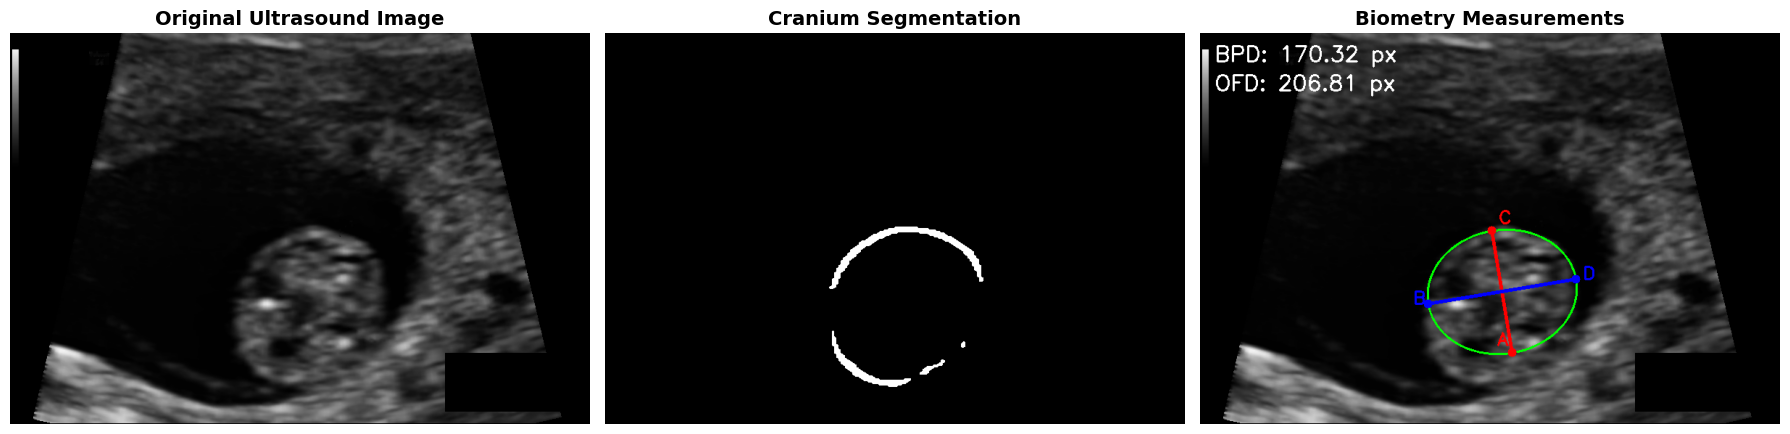

✓ Visualization saved to biometry_result.png

📥 Downloading trained model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Files downloaded!

All Done!



In [25]:
# ==================== Main Execution ====================
if __name__ == '__main__':
    # Check if running in Colab
    is_colab = setup_colab()

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'\n{"="*70}')
    print(f'Attention U-Net for Fetal Biometry Detection')
    print(f'{"="*70}')
    print(f'Device: {device}\n')

    # # Load dataset
    # if is_colab:
    #     print("\nChoose your data upload method:")
    #     print("  1. Upload zip files (images.zip and masks.zip)")
    #     print("  2. Use Google Drive")

    #     choice = input("\nEnter your choice (1 or 2): ").strip()

    #     if choice == "1":
    #         image_paths, mask_paths = upload_and_extract_dataset()
    #     else:
    #         mount_google_drive()
    #         # User needs to specify their Drive path
    #         drive_path = input("\nEnter path to your dataset folder in Drive\n(e.g., /content/drive/MyDrive/fetal_dataset): ").strip()
    #         image_dir = Path(drive_path) / 'images'
    #         mask_dir = Path(drive_path) / 'masks'

    #         image_paths = sorted(list(image_dir.rglob('*.png')) + list(image_dir.rglob('*.jpg')))
    #         mask_paths = sorted(list(mask_dir.rglob('*.png')) + list(mask_dir.rglob('*.jpg')))

    #         print(f"\n✓ Dataset loaded from Google Drive")
    #         print(f"  Images: {len(image_paths)}")
    #         print(f"  Masks: {len(mask_paths)}")
    # else:
    image_dir = Path('dataset/images/images')
    mask_dir = Path('dataset/masks/masks')
    image_paths = sorted(list(image_dir.glob('*.png')) + list(image_dir.glob('*.jpg')))
    mask_paths = sorted(list(mask_dir.glob('*.png')) + list(mask_dir.glob('*.jpg')))

    if image_paths is None or mask_paths is None or len(image_paths) == 0:
        print("\n✗ Error: No images found. Please upload your dataset.")
        exit()

    print(f'\nDataset: {len(image_paths)} images, {len(mask_paths)} masks\n')

    # Data augmentation
    train_transform = A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(256, 256),
        ToTensorV2()
    ])

    # Split dataset
    train_images, val_images, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42
    )

    print(f'Training set: {len(train_images)} images')
    print(f'Validation set: {len(val_images)} images\n')

    # Create datasets
    train_dataset = FetalCraniumDataset(train_images, train_masks, train_transform)
    val_dataset = FetalCraniumDataset(val_images, val_masks, val_transform)

    # Test dataset to ensure correct shapes
    print("Testing dataset shapes...")
    test_img, test_mask = train_dataset[0]
    print(f"  Sample image shape: {test_img.shape}")
    print(f"  Sample mask shape: {test_mask.shape}")
    print(f"  Expected: [1, 256, 256] for both\n")

    if test_img.dim() != 3 or test_img.shape[0] != 1:
        raise ValueError(f"Incorrect image shape! Got {test_img.shape}, expected [1, 256, 256]")

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model
    model = AttentionUNet(in_channels=1, out_channels=1, features=[64, 128, 256, 512]).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    print(f'Model Parameters: {total_params:,}\n')

    # Train
    history, best_dice = train_attention_unet(
        model, train_loader, val_loader,
        epochs=50, lr=1e-4, device=device,
        save_path='attention_unet_best.pth'
    )

    # Save history
    with open('training_history.json', 'w') as f:
        json.dump(history, f, indent=2)
    print(f'\n✓ Training history saved')

    # Load best model
    checkpoint = torch.load('attention_unet_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f'\n{"="*70}')
    print(f'Training Complete!')
    print(f'{"="*70}')
    print(f'Best Validation Dice: {best_dice:.4f}\n')

    # Test on sample
    if len(image_paths) > 0:
        print(f'{"="*70}')
        print(f'Testing on Sample Image')
        print(f'{"="*70}\n')

        test_image_path = image_paths[0]
        biometry_data, mask, _ = segment_and_measure(model, test_image_path, device)

        if biometry_data:
            print(f'\n✓ Biometry Measurements:')
            print(f'  BPD: {biometry_data["BPD_distance_px"]:.2f} pixels')
            print(f'  OFD: {biometry_data["OFD_distance_px"]:.2f} pixels')

            visualize_biometry(test_image_path, biometry_data, mask)
        else:
            print('\n✗ Failed to detect cranium')

    # Download model in Colab
    if is_colab:
        from google.colab import files
        print("\n📥 Downloading trained model...")
        files.download('attention_unet_best.pth')
        files.download('training_history.json')
        print("✓ Files downloaded!")

    print(f'\n{"="*70}')
    print(f'All Done!')
    print(f'{"="*70}\n')